In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import chi2_contingency

from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Functions
- The cell below holds functions that I have designed.
I would usually store them within a script saved in /src but for the sake of this project I will 
store them in the below cell.

In [2]:
def plot_histogram(df, column, bins=30):
    plt.figure(figsize=(8,5))
    plt.hist(df[column].dropna(), bins=bins, edgecolor='black', alpha=0.7)
    plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Mean: {df[column].mean():.2f}")
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def calculate_proportions(df, column_name):
    proportions = df[column_name].value_counts(normalize=True).round(3).sort_index(ascending=True)
    return proportions

def split_data(df, test_size=0.2):
       ''' 
       This function splits the data into training and testing
       datasets without allowing any leakage of horses
       from the same race into either dataset.
       '''
       # Get unique races
       unique_races = df['race_id'].unique()
        
       # Split the races into train and test sets
       train_races, test_races = train_test_split(unique_races, test_size=test_size, shuffle=True, random_state=42)
        
       # Split the dataframe based on the race ids
       train_data = df[df['race_id'].isin(train_races)]
       test_data = df[df['race_id'].isin(test_races)]
        
       return train_data, test_data

def normalize_columns(df, column_names):
        """
        Normalize specified columns in a df using MinMaxScaler.
        
        Parameters:
        df (pd.DataFrame): input df
        column_names (list): list of column names to normalize

        Returns:
        pandas.DataFrame: DataFrame with specified columns normalized

        Example Usage:
        > normalized_df = DataCleaning.normalize_columns(df, ['A', 'B'])
        """
        
        scaler = MinMaxScaler()
        df_normalized = df.copy()
        df_normalized[column_names] = scaler.fit_transform(df[column_names])

        return df_normalized

def eval_classification_model(test_target, predictions):
    # Evaluate the model
    accuracy = accuracy_score(test_target, predictions)
    precision = precision_score(test_target, predictions)
    recall = recall_score(test_target, predictions)
    f1 = f1_score(test_target, predictions)
    roc_auc = roc_auc_score(test_target, predictions)
    conf_matrix = confusion_matrix(test_target, predictions)
    # [[True Negatives, False Positives], 
    #    [False Negatives, True Positives]]

    return accuracy, precision, recall, f1, roc_auc, conf_matrix

def print_metrics(test_target, predictions):
    accuracy, precision, recall, f1, roc_auc, conf_matrix = eval_classification_model(test_target, predictions)
    
    print(f"\nConfusion Matrix: \n{conf_matrix}")
    print(f"Accuracy: {accuracy}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 score: {f1}')
    print(f'ROC AUC score: {roc_auc}')

def profit_calculation(df, stake = 1):
    """
    Calculate ROI, total returns from the model predictions.

    Args:
        df (pd.Dataframe): A dataframe that has a column holding the model predictions
        stake (int): The amount staked for each bet

    Returns:
        print() 
    """
    # Filter rows where model_preds == 1
    bets = df[df['model_preds'] == 1].copy()

    # Calculate returns
    bets['Return'] = bets.apply(
        lambda row: (row['obs__bsp'] - 1) * stake if row['obs__is_winner'] == 1 else -1,
        axis=1
    )

    # Total return
    total_return = bets['Return'].sum()

    # total number of bets
    total_bets = len(bets)

    # Calculate accuracy: Percentage of correct predictions where the model predicted 1 and won
    correct_predictions = bets[bets['obs__is_winner'] == 1].shape[0]

    if total_bets > 0:
        accuracy = (correct_predictions / total_bets) * 100  # Accuracy in percentage
        return_per_pound = total_return / (total_bets * stake)
    else:
        accuracy = 0
        return_per_pound = 0

    print(f"Total number of bets: {total_bets}")
    print(f"Total return from betting £{stake:.2f} on each prediction where model_preds == 1: £{total_return:.2f}")
    print(f"Return per pound invested: £{return_per_pound:.2f}")
    print(f"Model accuracy: {accuracy:.2f}%")

def monte_carlo_simulation(race):
    """
    race: DataFrame for a single race
    Returns profit if we bet £1 on a horse selected probabilistically.
    """
    # Choose a horse according to model probabilities
    chosen_horse = race.sample(n=1, weights=race['pred_prob_norm'])
    
    # Compute profit: (BSP - 1) if win, -1 if lose
    profit = (chosen_horse['obs__bsp'].values[0] - 1) if chosen_horse['obs__is_winner'].values[0] == 1 else -1
    return profit

In [3]:
df = pd.read_csv('test_dataset.csv')
df.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time
0,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21374,Eton Rambler,5,73.0,59.874193,3,5362,Pat Cosgrave,375,George Baker,7.8,9.12,82.0,3,3,0,48.0,2.5,721.50,155.95
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,5,69.0,58.059823,6,7227,William Twiston-Davies,367,Michael Scudamore,5.8,7.00,81.0,2,2,0,47.0,0.5,1443.75,155.61
2,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,26461,Marengo,4,69.0,54.884677,8,12949,Jordan Williams,762,Bernard Llewellyn,12.0,9.28,45.0,8,8,0,11.0,23.0,0.00,159.36
3,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,50069,Smoker,5,70.0,58.513416,2,5425,Oisin Murphy,126,Tim Vaughan,34.0,18.00,62.0,6,6,0,28.0,13.0,0.00,157.70
4,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,102542,Symphony Of Kings,4,74.0,60.327785,4,5481,Adam Kirby,414,Tony Carroll,7.6,7.40,77.0,5,5,0,44.0,6.0,0.00,156.53


## Initial EDA

In [4]:
df.dtypes

date                        object
racecourse_country          object
racecourse_name             object
race_time                   object
race_id                      int64
race_distance              float64
race_type                   object
race_type_simple            object
going_clean                 object
n_runners                    int64
horse_id                     int64
horse_name                  object
age                          int64
official_rating            float64
carried_weight             float64
draw                         int64
jockey_id                    int64
jockey_name                 object
trainer_id                   int64
trainer_name                object
ltp_5min                   float64
obs__bsp                   float64
obs__racing_post_rating    float64
obs__Place                  object
obs__uposition               int64
obs__is_winner               int64
obs__top_speed             float64
obs__distance_to_winner    float64
obs__pos_prize      

In [5]:
# returns a list of unique values
df["draw"].value_counts().head(10)

draw
0    316024
3     44689
2     44624
1     44624
4     44359
5     43663
6     41756
7     38632
8     34433
9     29517
Name: count, dtype: int64

In [6]:
# returns a list of unique values
df["draw"].value_counts().head(10)


draw
0    316024
3     44689
2     44624
1     44624
4     44359
5     43663
6     41756
7     38632
8     34433
9     29517
Name: count, dtype: int64

We can see that there is a high number of values with a draw value of 0. From my experience draw values are 1 or greater (for flat races).
This warrants further investigation as 'Draw' is known to have a major impact on the probabilities 
of horses winning at particular tracks and particular distances in flat races.

We are going to investigate if any flat races are affected by 'draw' == 0.

In [7]:
# Group by race_id and race_type_simple, then check if any draw == 0 in that race
draw_zero_races = (
    df.groupby(['race_id', 'race_type_simple'])['draw']
      .apply(lambda x: (x == 0).any())
      .reset_index(name='has_draw_zero')
)

# Now see which race types have races with draw == 0
draw_zero_counts = draw_zero_races.groupby('race_type_simple')['has_draw_zero'].sum().sort_values(ascending=False)
print(draw_zero_counts)

race_type_simple
Hurdle       18471
Chase        12055
Flat Turf     3075
Flat AW        174
Name: has_draw_zero, dtype: int64


### Display a histogram showing counts of field sizes.

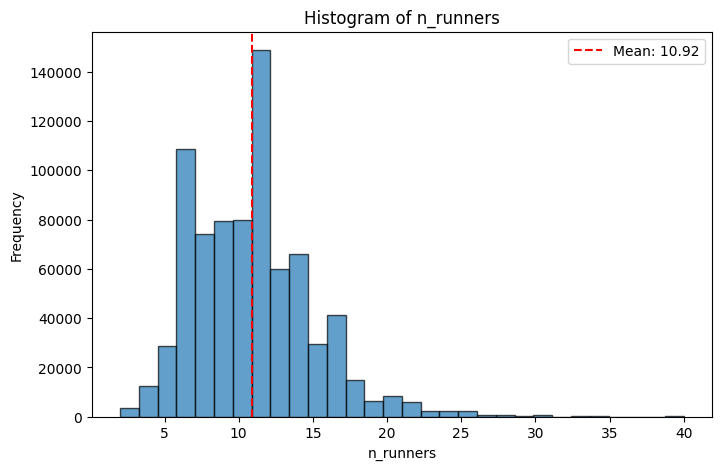

In [8]:
plot_histogram(df, "n_runners")


### Display a histogram showing counts of age of runners.

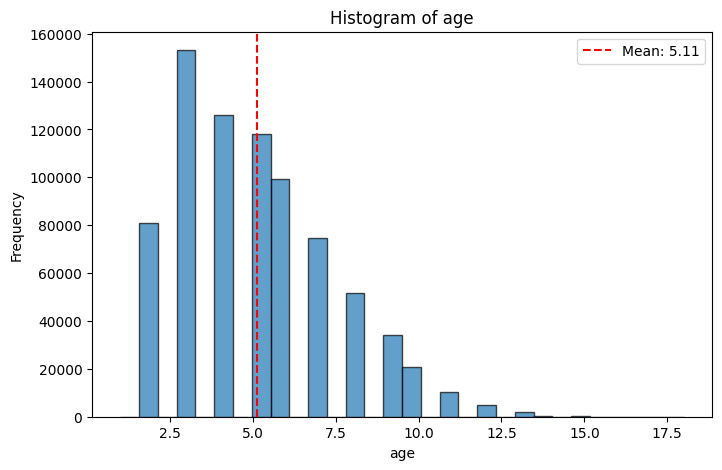

In [9]:
plot_histogram(df,'age')

## Data Cleaning and Feature Engineering

With the numeric columns, it is essential that there are no NaN values.
With the numeric columns all NaN's will be replaced with 0.

In [10]:
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

### Draw IV

This feature is used to show the impact value of a draw
by 'racecourse_name', 'race_distance', 'race_type' and 'going_clean'. I have done this as previous analysis
has shown the significant impact that stall number has for flat races at particular racetracks.

Due to the large number of flat races where we don't have values for 'draw' I may not use this in the modelling 
but I felt it was an important area to highlight for this assessment.

In [11]:
# create a draw IV feature.

# Columns: racecourse_name, race_distance, race_type, going_clean, draw, obs__is_winner
group_cols = ['racecourse_name', 'race_distance', 'race_type', 'going_clean', 'draw']

draw_stats = df.groupby(group_cols)['obs__is_winner'].agg(['sum', 'count']).reset_index()
draw_stats['win_pct'] = draw_stats['sum'] / draw_stats['count']

# Overall win rate per race conditions
overall_win_pct = df.groupby(['racecourse_name', 'race_distance', 'race_type', 'going_clean'])['obs__is_winner'].mean().reset_index()
overall_win_pct = overall_win_pct.rename(columns={'obs__is_winner':'overall_win_pct'})

# Merge with draw stats
draw_stats = draw_stats.merge(overall_win_pct, on=['racecourse_name', 'race_distance', 'race_type', 'going_clean'])
draw_stats['draw_iv'] = draw_stats['win_pct'] / draw_stats['overall_win_pct']

df = df.merge(draw_stats[['racecourse_name', 'race_distance', 'race_type', 'going_clean','draw', 'draw_iv']], 
              on=['racecourse_name', 'race_distance', 'race_type', 'going_clean', 'draw'], 
              how='left')

df[['date', 'race_time','racecourse_name', 'horse_name','draw', 'draw_iv']].head(10)

,date,race_time,racecourse_name,horse_name,draw,draw_iv
0,2015-05-01,13:40,Chepstow,Eton Rambler,3,0.000000
1,2015-05-01,13:40,Chepstow,Shades Of Silver,6,0.854545
2,2015-05-01,13:40,Chepstow,Marengo,8,0.000000
3,2015-05-01,13:40,Chepstow,Smoker,2,0.854545
4,2015-05-01,13:40,Chepstow,Symphony Of Kings,4,1.709091
5,2015-05-01,13:40,Chepstow,The Holyman,5,0.000000
6,2015-05-01,13:40,Chepstow,May Be Some Time,7,0.949495
7,2015-05-01,13:40,Chepstow,Air Squadron,1,1.553719
8,2015-05-01,13:50,Musselburgh,Copacobana,4,1.627614
9,2015-05-01,13:50,Musselburgh,Sadie Babes,3,0.969925


### Previous max speed
- Derive a feature from previous starts. This the maximum speed reached by a horse in previous starts, for certain types of races (especially sprint races) this a key metric.
- Could look at average career, average from last 3 starts, etc.

In [12]:
# Store original index
df['original_index'] = df.index

# Ensure obs__top_speed NaNs are 0
df['obs__top_speed'] = df['obs__top_speed'].fillna(0)

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute max_top_speed_prev per horse
df['max_top_speed_prev'] = df.groupby('horse_id')['obs__top_speed'].transform(
    lambda s: s.shift(1).cummax().fillna(0)
)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)

### Previous wins on this going
- Create a binary feature which shows if a horse has previously won on this going.

In [13]:
# Store original index
df['original_index'] = df.index

# Ensure the dataframe is sorted by horse and date
df = df.sort_values(['horse_id', 'date'])

df['won_on_going_prev'] = (
    df.groupby(['horse_id', 'going_clean'])['obs__is_winner']
      .transform(lambda x: x.shift().cummax().fillna(0))
)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)

### Create rank columns
- I am going to create some features that are derived from existing features in the dataset that could be useful for 
creating models with greater powers of prediction.
- This allows us to use a horses relative rank in a model instead of it's absolute value,
this can be very useful when a horse is moving between classes.
- ltp_rank is derived from the ltp_5min column as the starting price is given at the off and we would need to utilize the model before the race starts.

### Create a feature that indicates the rank of ltp_5min for each horse, race combination

In [77]:
df['ltp_rank'] = (
    df.groupby(['date', 'racecourse_name', 'race_time'])['ltp_5min']
    .rank(method='min', ascending=True)
)

### Create a feature that indicates the rank of official_rating for each horse, race combination


In [78]:
df['rating_rank'] = (
    df.groupby(['date', 'racecourse_name', 'race_time'])['official_rating']
    .rank(method='min', ascending=False)
)

### Create a column that shows the career max speed achieved by a horse

In [79]:
# Store original index
df['original_index'] = df.index

# Ensure obs__top_speed NaNs are 0
df['obs__top_speed'] = df['obs__top_speed'].fillna(0)

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute max_top_speed_prev per horse
df['max_top_speed_prev'] = df.groupby('horse_id')['obs__top_speed'].transform(
    lambda s: s.shift(1).cummax().fillna(0)
)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)


### Calculate the amount of prize money won in previous starts.

In [80]:
# Store original index
df['original_index'] = df.index

# Ensure prize column has no NaNs
df['obs__pos_prize'] = df['obs__pos_prize'].fillna(0)

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute cumulative prize money per horse, excluding current race
df['horse_cum_prize_prev'] = df.groupby('horse_id')['obs__pos_prize'].transform(
    lambda s: s.shift(1).cumsum().fillna(0)
)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)

### Calculate the number of previous starts.

In [81]:
# Store original index
df['original_index'] = df.index

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute cumulative starts per horse, excluding current race
df['horse_cum_starts_prev'] = df.groupby('horse_id').cumcount().fillna(0)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)


### Calculate the average prize money won per start
- This can help to compare horses that have run in different classes, 
for example a horse that has placed in class 1 vs a horse that has won in class 2.
- I believe this is an important metric to help determine the 'class' of a runner.

In [82]:
df['ave_prize_per_start'] = (df['horse_cum_prize_prev'] / df['horse_cum_starts_prev']).round().fillna(0)

### Calculate an avg. PRB metric
- PRB == percentage of rivals beaten.
- Very important to note that avg_prb is a historical measure, it is calculated on past performances.
- This helps us to understand the merits of unplaced runs, for example finishing 5 of 16 is a vastly 
different performance than finishing 5 of 6.

In [83]:
df['prb'] = (df['n_runners'] - df['obs__uposition']) / (df['n_runners'] - 1)

# Sort by horse and date to ensure correct cumulative calculation
df = df.sort_values(['horse_id', 'date'])

# Compute cumulative average PRB per horse, ignoring current race
df['avg_prb'] = df.groupby('horse_id')['prb'].transform(
    lambda x: x.shift(1).expanding().mean().fillna(0).round(2)
)


## EDA

### Look at the proportions for various features

Below we can see at 34.2% of the time, across all race types that the horse with the lowest value for 'ltp_5min' (ie, the favourite)
will win the race.

In [84]:
winners = df[df['obs__is_winner'] == 1]

win_props = calculate_proportions(winners, 'ltp_rank')
win_props.head(10)

ltp_rank
1.0     0.342
2.0     0.202
3.0     0.138
4.0     0.097
5.0     0.071
6.0     0.049
7.0     0.034
8.0     0.024
9.0     0.015
10.0    0.010
Name: proportion, dtype: float64

Below we can see that 32.6% of the time, across all race types that the horse with the highest value for 'official_rating'
will win the race.

In [85]:
rating_props = calculate_proportions(winners, 'rating_rank')
rating_props.head(10)

rating_rank
1.0     0.326
2.0     0.166
3.0     0.121
4.0     0.093
5.0     0.074
6.0     0.059
7.0     0.046
8.0     0.034
9.0     0.025
10.0    0.019
Name: proportion, dtype: float64

# Investigate the peak age of horses

### Chi squared test
- For this exercise I firstly want to see if horse age affects the win rate within each race type.
- I will create a contigency table and then compute the chi sq. values to see if age is statistically significant.
- If the p-value is less than 0.05, winning is strongly associated with age.

In [86]:
results = []

for race_type in df['race_type_simple'].unique():
    df_sub = df[df['race_type_simple'] == race_type]
    
    # Create contingency table: rows=age, columns=win/loss
    contingency = pd.crosstab(df_sub['age'], df_sub['obs__is_winner'])
    
    # Skip if there are not enough observations
    if contingency.sum().sum() < 10:
        continue
    
    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    results.append({
        'race_type_simple': race_type,
        'chi2': chi2,
        'p_value': p,
        'degrees_of_freedom': dof
    })

# Convert results to DataFrame
chi2_results = pd.DataFrame(results)

print(chi2_results)


  race_type_simple        chi2        p_value  degrees_of_freedom
0           Hurdle  425.246654   6.019582e-82                  14
1        Flat Turf  512.948608   1.028918e-99                  15
2          Flat AW  332.420077   1.987814e-62                  14
3            Chase  605.583029  4.946765e-121                  13


The analysis below shows p-values < than 0.05. Across all race types, winning is strongly associated with age.

### Determine the peak age by the proportion of winners to runners.

In [87]:
# Calculate profit per horse
df['profit'] = df.apply(
    lambda row: row['obs__bsp'] - 1 if row['obs__is_winner'] == 1 else -1,
    axis=1
)

# Group by race type and age, calculate win rate and ROI
performance_age = (
    df.groupby(['race_type_simple', 'age'])
    .agg(
        runs=('obs__is_winner', 'count'),
        wins=('obs__is_winner', 'sum'),
        roi=('profit', 'mean')  # average profit per £1 bet
    )
    .reset_index()
)

performance_age['win_rate'] = performance_age['wins'] / performance_age['runs']

# Find the age with highest win rate for each race type
peak_age_per_type = performance_age.loc[
    performance_age.groupby('race_type_simple')['win_rate'].idxmax(),
    ['race_type_simple', 'age', 'win_rate', 'roi']
].rename(columns={
    'age': 'peak_age', 
    'win_rate': 'peak_win_rate',
    'roi': 'peak_age_roi'
})

print(peak_age_per_type)

   race_type_simple  peak_age  peak_win_rate  peak_age_roi
0             Chase         4       0.190317      0.094073
27          Flat AW        15       0.142857      3.000000
31        Flat Turf         3       0.115186     -0.002965
58           Hurdle        16       0.166667      1.000000


It is really interesting to see peak ages of 15 for Flat AW and 16 for Hurdle race types. This needs further investigating as my gut feeling is that this is an anamoly of some description

In [88]:
performance_age.loc[[0,27,31,58]]

,race_type_simple,age,runs,wins,roi,win_rate
0,Chase,4,599,114,0.094073,0.190317
27,Flat AW,15,7,1,3.000000,0.142857
31,Flat Turf,3,96479,11113,-0.002965,0.115186
58,Hurdle,16,6,1,1.000000,0.166667


The output above shows really small sample sizes for age 15 and Flat AW as well as age 16 and Hurdle.



### Re run peak age analysis with a minimum number of runner's threshold.
- I have set minimum runs to 30 per age, race type grouping.

In [89]:
min_runs = 30

# Calculate profit per horse
df['profit'] = df.apply(
    lambda row: row['obs__bsp'] - 1 if row['obs__is_winner'] == 1 else -1,
    axis=1
)

# Group by race type and age, calculate win rate and ROI
performance_age = (
    df.groupby(['race_type_simple', 'age'])
    .agg(
        runs=('obs__is_winner', 'count'),
        wins=('obs__is_winner', 'sum'),
        roi=('profit', 'mean')  # average profit per £1 bet
    )
    .reset_index()
)

performance_age['win_rate'] = performance_age['wins'] / performance_age['runs']
performance_age_filtered = performance_age[performance_age['runs'] >= min_runs]

# Find the age with highest win rate for each race type
peak_age_per_type = performance_age_filtered.loc[
    performance_age_filtered.groupby('race_type_simple')['win_rate'].idxmax(),
    ['race_type_simple', 'age', 'win_rate', 'roi']
].rename(columns={
    'age': 'peak_age', 
    'win_rate': 'peak_win_rate',
    'roi': 'peak_age_roi'
})

print(peak_age_per_type)

   race_type_simple  peak_age  peak_win_rate  peak_age_roi
0             Chase         4       0.190317      0.094073
15          Flat AW         3       0.115068      0.012715
31        Flat Turf         3       0.115186     -0.002965
48           Hurdle         6       0.113307     -0.071038


Blindly backing to a fixed stake would result in a negative ROI for Flat Turf and Hurdle.

We have to be really careful using this analysis due the nature of racing. Horses will sometimes compete only against horses of their own age (particulary 2 and 3 year olds). Handicap vs non handicap races need to be taken into consideration as well as the sex of the horse (allowances given to fillies and mares).

We really need a more nuanced view than just age.

# Feature engineering: Build a rating for each horse, jockey and trainer

I am building a trainer rating based of an Actual vs Expected metric. I am 
using the 'obs_bsp' column to determine expected winners as determined by the market.

A trainer is outperforming the market if the A/E value is greater than 1 and underperforming if the value is less than 0.

In [90]:
# Keep original index
df['original_index'] = df.index

# Calculate SP percentage (expected wins contribution per runner)
df['sp_pct'] = 1 / (df['obs__bsp'] + 1)

# Sort by trainer, date, and original index (ensures consistent order)
df = df.sort_values(['trainer_id', 'date', 'original_index']).copy()

# Cumulative actual wins and expected wins BEFORE the current race
df['trainer_cum_actual'] = (
    df.groupby('trainer_id')['obs__is_winner']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

df['trainer_cum_expected'] = (
    df.groupby('trainer_id')['sp_pct']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

# A/E ratio
df['trainer_rating'] = df['trainer_cum_actual'] / df['trainer_cum_expected']
df['trainer_rating'] = df['trainer_rating'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index'])


### Using the same logic as above, a rating can be determined for jockeys.

In [91]:
# Keep original index
df['original_index'] = df.index

# Sort by trainer, date, and original index (ensures consistent order)
df = df.sort_values(['jockey_id', 'date', 'original_index']).copy()

# Cumulative actual wins and expected wins BEFORE the current race
df['jockey_cum_actual'] = (
    df.groupby('jockey_id')['obs__is_winner']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

df['jockey_cum_expected'] = (
    df.groupby('jockey_id')['sp_pct']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

# A/E ratio
df['jockey_rating'] = df['jockey_cum_actual'] / df['jockey_cum_expected']
df['jockey_rating'] = df['jockey_rating'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index'])

### Calculate a rating for horses
- For this rating I will take three variables and assign an equal weight of 0.33 to each of them.

In [92]:
df['horse_rating'] = 0.33 * df['max_top_speed_prev'] + 0.33 * df['ave_prize_per_start'] + 0.33 * df['avg_prb']

## Build a predictive model

In [93]:
print(len(df))

777549


I am going to remove ALL races where at least one horse (market participant) is having its first start. 
This is due to the fact that features that have been created on historical data. This will mean every horse having it's first run will feature values equal to 0, which not not ideal for creating a strong predictive model.

In [94]:
# List the columns you want to check
cols_to_check = ['max_top_speed_prev', 'ave_prize_per_start', 'avg_prb']

# Find race_ids where ANY horse has a 0 in ALL three of those columns
bad_races = df.loc[(df[cols_to_check] == 0).all(axis=1), 'race_id'].unique()

# Remove those races from the dataframe
df_filtered = df[~df['race_id'].isin(bad_races)].copy()

print(len(df_filtered))

524808


### Normalize specified numeric values

In [95]:
numeric_cols = ['max_top_speed_prev', 'ave_prize_per_start',
               'avg_prb', 'trainer_rating', 'jockey_rating', 'horse_rating', 'official_rating']

normalized_df = normalize_columns(df_filtered, numeric_cols)

In [96]:
normalized_df.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,draw_iv,ltp_rank,rating_rank,max_top_speed_prev,horse_cum_prize_prev,horse_cum_starts_prev,ave_prize_per_start,prb,avg_prb,profit,sp_pct,trainer_cum_actual,trainer_cum_expected,trainer_rating,jockey_cum_actual,jockey_cum_expected,jockey_rating,horse_rating
9547,2015-05-26,GB,Redcar,16:50,174447,1005.84,Flat,Flat Turf,Firm,8,2185,Rozene,4,0.418079,54.884677,9,1529,Rob Hornby,31,David Barron,3.1,2.94,66.0,7,7,0,53.0,5.35,0.0,59.13,1.059432,1.0,6.0,0.384181,4528.3,1,0.006355,0.142857,1.00,-1.00,0.253807,8.0,4.364232,0.019324,4.0,1.881449,0.016237,0.006451
9548,2015-05-26,GB,Redcar,16:50,174447,1005.84,Flat,Flat Turf,Firm,8,31676,Jacob's Pillow,4,0.440678,58.967008,1,5,Graham Lee,179,Jedd O'Keeffe,12.0,10.82,69.0,8,8,0,56.0,5.65,0.0,59.19,1.222421,6.0,2.0,0.209040,0.0,1,0.000000,0.000000,0.09,-1.00,0.084602,3.0,1.724999,0.018334,13.0,11.508847,0.008627,0.000052
9549,2015-05-26,GB,Redcar,16:50,174447,1005.84,Flat,Flat Turf,Firm,8,32045,Singeur,8,0.429379,58.059823,8,147,Daniel Tudhope,67,Rebecca Bastiman,7.0,10.06,88.0,1,1,1,76.0,0.00,6469.0,58.16,0.866808,3.0,4.0,0.310734,0.0,2,0.000000,1.000000,0.35,9.06,0.090416,1.0,0.623506,0.016907,10.0,7.098124,0.010760,0.000078
9550,2015-05-26,GB,Redcar,16:50,174447,1005.84,Flat,Flat Turf,Firm,8,33253,Flash City,7,0.423729,57.606231,7,15,James Sullivan,26,Ruth Carr,11.5,8.45,71.0,4,4,0,58.0,4.25,481.0,58.93,1.191860,5.0,5.0,0.367232,0.0,2,0.000000,0.571429,0.54,-1.00,0.105820,4.0,4.381909,0.009623,4.0,4.307012,0.007093,0.000092
9551,2015-05-26,GB,Redcar,16:50,174447,1005.84,Flat,Flat Turf,Firm,8,33387,Imperial Legend,6,0.440678,55.791862,5,518,Miss Anna Hesketh,23,David Nicholls,6.0,7.00,86.0,2,2,0,74.0,1.00,1925.0,58.34,1.135105,2.0,2.0,0.429379,1925.0,2,0.001350,0.857143,0.77,-1.00,0.125000,3.0,2.060354,0.015350,0.0,0.465507,0.000000,0.001458


### Correlation matrix
- I am going to use a correlation matrix to investigate the pairwise relationship between features in the dataset. This allows us to see the strength and direction of their linear relationships.

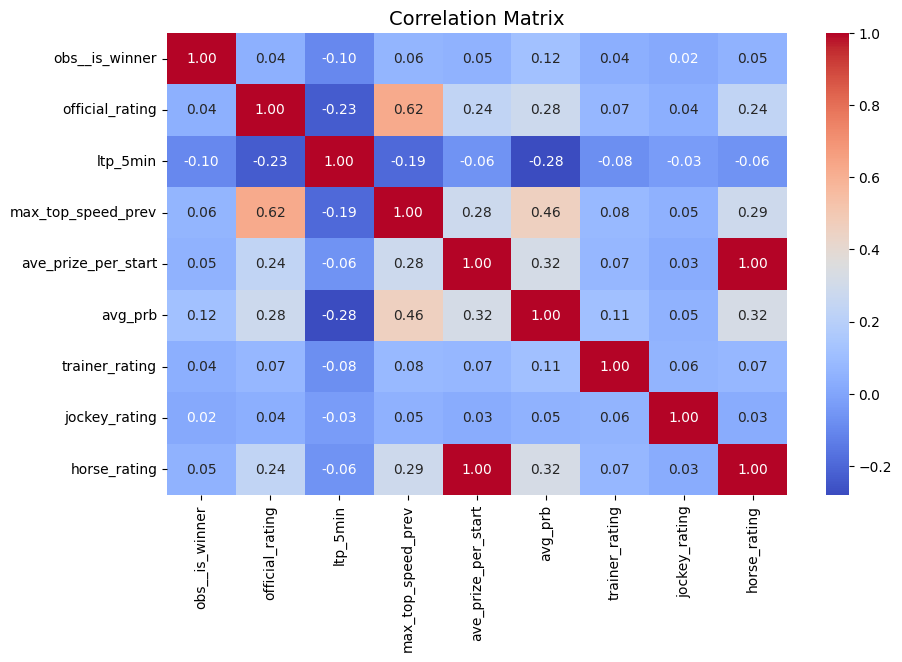

In [97]:
subset_cols = ['obs__is_winner', 'official_rating', 'ltp_5min', 'max_top_speed_prev', 'ave_prize_per_start',
               'avg_prb', 'trainer_rating', 'jockey_rating', 'horse_rating']

subset_df = normalized_df[subset_cols]

# Compute correlation matrix
corr_matrix = subset_df.corr()

# Display as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

- Investigating the correlation m atrix above shows some interesting relationships. There is a strong positive reltionship between the official rating and the maximum top speed achieved by a horse in previous starts. There is also a strong positive relationship between the average percentage of rivals beaten and the maximum top speed achieved by a horse in previous starts.

- Looking at 'obs__is_winner', there is no very strong linear relationships with the other variables in the correlation matrix. This may be due to the fact that the relationship is non linear or that simply I need to find features that have a more stronger relationship. There is a negative linear relation between the features 'obs__is_winner' and 'bsp_5min'. This is due the inverse relation between the probability of a horse winning and the price/ odds offered.

- Looking at the correlation matrix, one potential methodology could be around modelling a handicap rating. We could then look for an edge that could be exploited in handicap races where the weight a horse carries is determined by a rating. 

### Create a training and testing dataset

In [98]:
feature_cols = ['trainer_rating', 'jockey_rating', 'horse_rating']   
target = 'obs__is_winner'

train_data, test_data = split_data(normalized_df)

X_train = train_data[feature_cols]
y_train = train_data[target]
X_test = test_data[feature_cols]
y_test = test_data[target]

### Start with a baseline model.
- Our baseline model is going to be simply backing every market favourite using 'obs__bsp'. Over the long term, ~33% of the time the favourite wins (flat racing). From my experience it is a fairly popular system and there is a cohort of professional gamblers who only back favourites.

- Important assumption here is that the bet is placed at the price given by 'ltp_5min'. It would be interesting to see the profit and ROI if taking the starting price.
I will circle back to this if I have time.

- With this scenario we are betting on every favourite including races with joint favourites (may have multiple bets in the same race). There could be scenario where we don't bet into markets with joint favourites or could possibly split the stakes across joint favourites but for thes ake of this exercise we will bet to level stakes on all favourites.

In [100]:
test_data0 = test_data.copy()

# Calculate profit for £1 bet on favourites
test_data0['fav_profit'] = 0.0
test_data0.loc[(test_data0['ltp_rank'] == 1) & (test_data0['obs__is_winner'] == 1), 'fav_profit'] = test_data0['obs__bsp'] - 1 # important to note profit is (bsp - 1)
test_data0.loc[(test_data0['ltp_rank'] == 1) & (test_data0['obs__is_winner'] == 0), 'fav_profit'] = -1 # if bet loses, lose the stake

# Total profit
total_profit = test_data0['fav_profit'].sum()

# ROI
n_races = test_data0['race_id'].nunique()
n_bets = (test_data0['ltp_rank'] == 1).sum()
roi = total_profit / n_bets

print(f'Total number of races: {n_races}')
print(f'Total number of bets placed: {n_bets}')
print(f'Total Profit: £{total_profit:.2f}')
print(f'ROI per £1 staked: {roi:.2%}')


Total number of races: 11314
Total number of bets placed: 11659
Total Profit: £-26.97
ROI per £1 staked: -0.23%


### Create a plot for cumultaive profit to a £1 stake


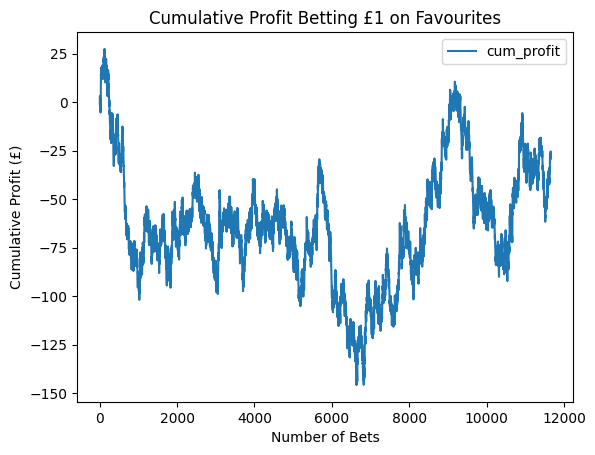

In [101]:
test_data0['bet_number'] = (test_data0['ltp_rank'] == 1).cumsum()
test_data0['cum_profit'] = test_data0['fav_profit'].cumsum()

plot_data = test_data0.loc[test_data0['ltp_rank'] == 1, ['bet_number', 'cum_profit']]

plot_data.plot(x='bet_number', y='cum_profit', title="Cumulative Profit Betting £1 on Favourites")
plt.xlabel("Number of Bets")
plt.ylabel("Cumulative Profit (£)")
plt.show()


We can see this is not a profitable strategy, but it gives a good starting point to improve from.

### Train a gradient booster classifier
- I am using a GBC for a few reasons.
- Firstly, its easy to implement which is important for this task due the turn around time.
- The strengths of this model are that it handles non linear relationships, it outputs probabilities, 
works well with tabular data and being a tree based ensemble model it is great at avoiding overfitting.



### Dealing with an imbalanced dataset.
- It is important to note the imbalanced nature of this dataset when using 'obs__is_winner' as the dependent variable.
In the vast majority of race there is only one winner with multiple losers.

In [102]:
# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(f"Length of  X_train: {len(X_train)}\nLength of y_train: {len(y_train)}")
print(f"\nLength of  X_resampled: {len(X_resampled)}\nLength of y_resampled: {len(y_resampled)}")

Length of  X_train: 420213
Length of y_train: 420213

Length of  X_resampled: 749916
Length of y_resampled: 749916


In [103]:
test_data2 = test_data.copy()

# Instantiate and train the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_gbx = gb_classifier.predict(X_test)

test_data2['model_preds'] = y_pred_gbx

# Get predicted probabilities for the positive class (horse wins)
test_data2['pred_prob'] = gb_classifier.predict_proba(X_test)[:, 1]

# Normalize probabilities per race so that sum = 1
test_data2['pred_prob_norm'] = test_data2.groupby('race_id')['pred_prob'].transform(lambda x: x / x.sum())

test_data2['derived_model_price'] = 1 / test_data2['pred_prob_norm']



In [104]:
print_metrics(y_test, y_pred_gbx)
print()
profit_calculation(test_data2)


Confusion Matrix: 
[[48888 44393]
 [ 4308  7006]]
Accuracy: 0.5343850088436349
Precision: 0.1363061538162221
Recall: 0.6192328089093159
F1 score: 0.22343054869006426
ROC AUC score: 0.571663337913776

Total number of bets: 51399
Total return from betting £1.00 on each prediction where model_preds == 1: £319.53
Return per pound invested: £0.01
Model accuracy: 13.63%


- The output above shows that the model is profiatble with a total return of £319.53 from 51,399 bets. The ROI per £1.00 is £0.01. From these bets, 44,393 are false positive's meaning that model identified themm as winners but they were actual loser's. There 4,308 false negatives, meaning that model failed to identify 4,308 winners from the test dataset.

- The ROC AUC of 0.57 shows that model performs better than random guessing (it has predictive power, 0.5 represents random guessing 1.0 equals perfect predictive power.)

- The recall value is good and it means the model correctly identifies 62% of winners

- However the precision score is worrying, meaning that only 14% of the models predictions win.

- With no commision rates we are able to make a small ROI. However if the commision rate was 1% we would break even, however this system would lose money if the commission rate was 2%.

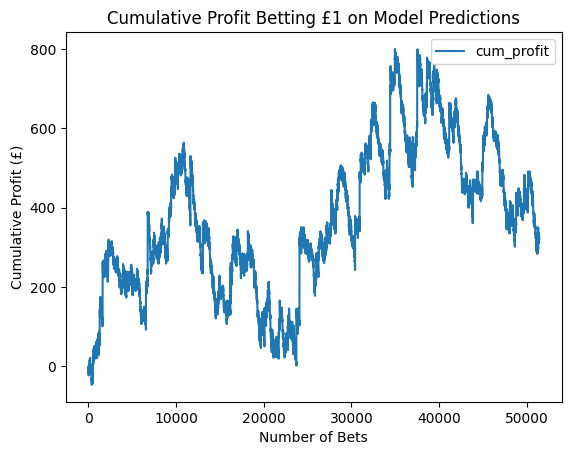

In [105]:
# Calculate profit for £1 bet on favourites
test_data2['preds_profit'] = 0.0
test_data2.loc[(test_data2['model_preds'] == 1) & (test_data2['obs__is_winner'] == 1), 'preds_profit'] = test_data2['obs__bsp'] - 1 # important to note profit is (bsp - 1)
test_data2.loc[(test_data2['model_preds'] == 1) & (test_data2['obs__is_winner'] == 0), 'preds_profit'] = -1 # if bet loses, lose the stake

# Total profit
total_profit = test_data2['preds_profit'].sum()


test_data2['bet_number'] = (test_data2['model_preds'] == 1).cumsum()
test_data2['cum_profit'] = test_data2['preds_profit'].cumsum()

plot_data = test_data2.loc[test_data2['model_preds'] == 1, ['bet_number', 'cum_profit']]

plot_data.plot(x='bet_number', y='cum_profit', title="Cumulative Profit Betting £1 on Model Predictions")
plt.xlabel("Number of Bets")
plt.ylabel("Cumulative Profit (£)")
plt.show()

### Monte carlo simulations
- Monte carlo simulations are an important tool to help simulate betting scenarios. Using monte carlo simulations we can look at the distribution of returns rather than a single point estimate. Monte carlo simulations help measure expected profitability and risk. Risk is very important as all systems will go through losing steaks, even with a positive edge and short term variance can wipe out a 'betting bank'.
- Monte carlo allows models to be simulated 'n' number of times allowing us to see how long losing runs may go, the profitability of increasing stake size and the risk of ruin.

In [36]:
# Copy the test data
mc_df = test_data2.copy()

# Number of Monte Carlo iterations
n_simulations = 1000
results = []

for i in range(n_simulations):
    # Group by race and simulate each race
    total_profit = mc_df.groupby('race_id').apply(monte_carlo_simulation).sum()
    results.append(total_profit)

# Convert to array for analysis
results = np.array(results)

# Expected profit and risk
expected_profit = results.mean()
profit_std = results.std()


### Visualiaze and interpret the monte carlo simulation
- Using the output from the monte carlo simulation we can derive some understanding from the histogram.
- Long tails (skewness) show rare but extreme outcomes (big wins or big losses) which are crucial to understanding risk.
- We are looking for a histogram that is narrow, as this shows a low variability in outcomes.
- We are looking for histogram to be centred around a positive value as this shows this model is profitable on average.
- I have added 95% CI's to show were roughly 95% of the outcomes fall between.

Monte Carlo simulations (1000 runs):
Expected total profit: £-199.70
Standard deviation (risk): £473.11


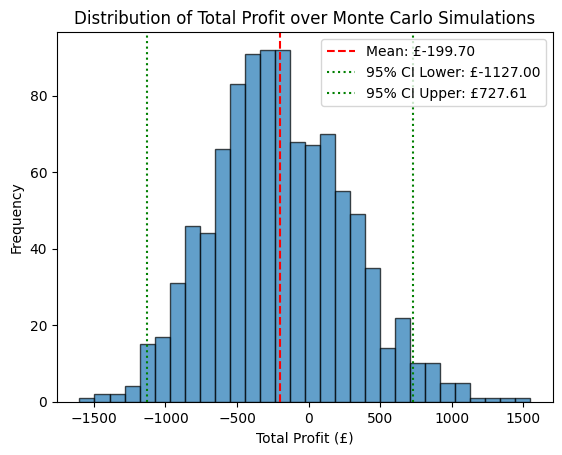

In [ ]:
print(f"Monte Carlo simulations: ({n_simulations} runs)")
print(f"Expected total profit: £{expected_profit:.2f}")
print(f"Standard deviation (risk): £{profit_std:.2f}")

mean_profit = np.mean(results)
std_profit = np.std(results)
ci_lower = mean_profit - 1.96 * std_profit  # 95% CI lower bound
ci_upper = mean_profit + 1.96 * std_profit  # 95% CI upper bound

plt.hist(results, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(mean_profit, color='r', linestyle='--', label=f'Mean: £{mean_profit:.2f}')
plt.axvline(ci_lower, color='g', linestyle=':', label=f'95% CI Lower: £{ci_lower:.2f}')
plt.axvline(ci_upper, color='g', linestyle=':', label=f'95% CI Upper: £{ci_upper:.2f}')

plt.title("Distribution of Total Profit over Monte Carlo Simulations")
plt.xlabel("Total Profit (£)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The ouput from the Monte Carlo simulations shows the distribution of outcomes rather than relying soley on expected profit. 
- Running this straegy many times would reuslt in a loss of on average £199.70. 
- The histogram shows the frequency of expected profits. We can see scenarios of making profits of over £1500 but also scenrios where the predictions result in losses of £-1500. 
- The confidence intervals show that 95% of profits will fall between £-1127.00 and £727.61. 
- The standard deviation measures the volatility of the model and it shows that even though the average outcome is a loss, individual runs of the model could result in heavy losses or potential wins.

## Final thoughts.
- There is fair degree of complexity needed to create a profitable system in the long run.
- My opinion is that this problem is less about the modelling and more about data quality and feature engineering.
- Train models on subsets of data (class, going, left handed track vs right handed track).
- Undulating tracks is a major, major factor. Can three year olds handle the track of Epsom or Goodwood????
- Creating pipelines are essential. Data preprocessing and then use the pipeline to gain inference from the correct model. (ie model for 10 furlongs, right handed, undulating, colts only race).
- Instead of just picking winners, what about picking place getters? Also merit in trying to identify incorrectly handicapped horses. As a horse been incorrectly weighted and can an edge be exploiited?


